In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from collections import defaultdict
import re

In [2]:
# Load data
corecare = (json.load(open('data/corecare.json')))['hits']
km = (json.load(open('data/km.json')))['hits']
cccm = (json.load(open('data/cccm.json')))['hits']
rcm = (json.load(open('data/rcm.json')))['hits']
combined_data = corecare + km + cccm + rcm

error_messages = [hit["_source"]["case_error"] for hit in combined_data]

In [3]:
# Initialize counts for each category
error_counts = defaultdict(int)

error_xpath = []
error_others = []

# Classify error messages into categories
for index, value in enumerate(error_messages):
    if "expected element with selector" in value.lower() or "element wasn't found" in value.lower() or "not displayed" in value.lower() or "not be displayed" in value.lower():
        error_counts["XPath Errors"] += 1
        error_xpath.append(value.split('\n')[0])
    else:
        error_counts["Other Errors"] += 1
        error_others.append(value.split('\n')[0])

# Print the counts for each category
for category, count in reversed(error_counts.items()):
    print(f"{category}: {count}")

XPath Errors: 11037
Other Errors: 5674


In [4]:
# Group XPath Errors
xpath_counts = defaultdict(int)
xpath_total_count = 0
for error in error_xpath:
    error = re.sub(r"\".*\"", '<ELEMENT_SELECTOR>', error)
    error = re.sub(r"->.*\]", '<ELEMENT_SELECTOR>', error)
    error = re.sub(r"(?<=\s)'[^']*'(?=\s)", '<ELEMENT_SELECTOR>', error)
    error = re.sub(r"Expected element -> [^\s]+", 'Expected element <ELEMENT_SELECTOR>', error)
    error = re.sub(r"[^\s]*<ELEMENT_SELECTOR>[^\s]*", '<ELEMENT_SELECTOR>', error)

    error = re.sub('AssertionError: ERROR - ENV: ', '', error)
    error = re.sub(r"AssertionError: \[!\] Validation Error: ", '', error)
    error = re.sub('Error: ERROR - ENV: ', '', error)
    error = re.sub('Error: ', '', error)
    error = re.sub('Expected ', '', error)

    error = re.sub(' with selector', '', error)
    error = re.sub(' on the page', '', error)
    error = re.sub('to be', 'not', error)
    error = re.sub('still not', 'not', error)
    error = re.sub('waitUntil condition failed with the following reason: ', '', error)
    error = re.sub('ERROR - ENV: ', '', error)


    error = re.sub(r"the given timeout (\d+)", '<TIMEOUT_PERIOD>', error)
    error = re.sub(r"\d+ms", '<TIMEOUT_PERIOD>', error)

    error = re.sub(r"Can't call (\S+)", r"Can't call <FUNCTION>", error)

    error = re.sub(r'^(\w)(.*)', lambda match: match.group(1).upper() + match.group(2).lower(), error)
    error = re.sub(r'(<.*?>)', lambda match: match.group(1).upper(), error)

    xpath_counts[error] += 1
    xpath_total_count += 1

# Convert counts to list of dictionaries
xpath_list = [{"error": error, "count": count} for error, count in xpath_counts.items()]
xpath_list = sorted(xpath_list, key=lambda x: x['count'], reverse=True)

# Write to JSON file
with open('xpath_errors.json', 'w') as f:
    json.dump(xpath_list, f, indent=4)

print("File written to 'xpath_errors.json'")
print("Total count: ", xpath_total_count)

File written to 'xpath_errors.json'
Total count:  11037


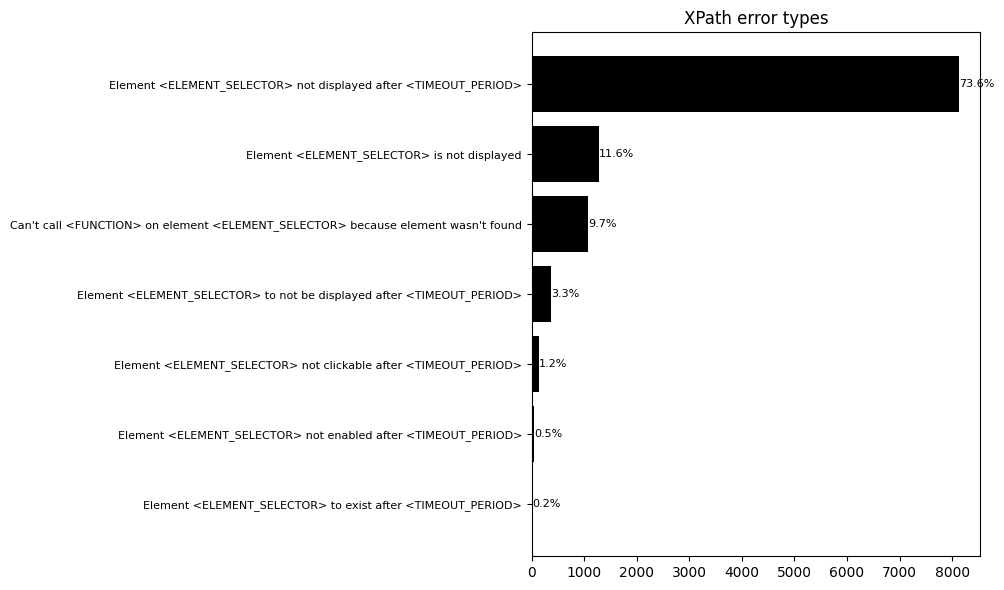

In [5]:
# Visualize data
# Extracting error messages and counts
errors = [item['error'] for item in xpath_list]
counts = [item['count'] for item in xpath_list]

# Calculate percentage for each error count
total_counts = sum(counts)
percentages = [(count / total_counts) * 100 for count in counts]

# Creating the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(errors, counts, color='black')

# Add percentages above each bar
for i, count in enumerate(counts):
    # Adjusting font size and adding line break
    plt.text(count, i, f'{percentages[i]:.1f}%', fontsize=8, ha='left', va='center')

plt.title('XPath error types')
plt.yticks(fontsize=8)  # Adjusting font size of y-axis labels
# Invert y-axis to display the highest count at the top
plt.gca().invert_yaxis()
plt.tight_layout()

# Show the plot
plt.show()
